## Data prep and training notebook
### CS445 Final Project, Spring 2020
#### Pranav Velamakanni (pranavv2), Tarik Koric (koric1)

In [32]:
import keras

In [695]:
from keras.layers import Dense, Conv2D, Input, MaxPool2D, UpSampling2D, Concatenate, Conv2DTranspose
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras import backend as K

from tqdm.notebook import tqdm

# Split test, train data
from sklearn.model_selection import train_test_split

# Import os for system level operations
import os, shutil

# Array operations
import numpy as np

# Image processing with OpenCV
import cv2

from scipy.misc import imresize

from keras.preprocessing.image import array_to_img, img_to_array, load_img, ImageDataGenerator

In [34]:
import matplotlib.pyplot as plt

In [663]:
### Sample input and annotated images

### Train

# Model 1
train_images = 'data/person/'
train_images_masks = 'data/person_mask/'

# Model 2
train2_images = 'data/cat/'
train2_images_masks = 'data/cat_mask/'

# Model 3
train3_images = 'data/dog/'
train3_images_masks = 'data/dog_mask/'

# Model 4 (combines all 3)
train4_images = 'data/all/'
train4_images_masks = 'data/all_mask/'

In [642]:
def read_image(dir_path, get = None, gray = None) -> list:
    '''
    Given a directory of images, reads the image and returns a list of arrays containing the pixel values.
    get defaults to all, if selected returns get number of images. 
    '''
    
    # Check if directory exists
    assert os.path.exists(dir_path)
    
    # Return list containing the arrays of images
    result = list()
    
    for file in os.listdir(dir_path):
        if gray:
            result.append(load_img(dir_path + file))
        else:
            result.append(cv2.cvtColor(cv2.imread(dir_path + file), cv2.COLOR_BGR2RGB))
        if get and len(result) == get:
            break
        
    return result

def generate_mask(source_dir, remove_dir, target_dir = None, pixel_limit = 240):
    '''
    Given a directory containing cropped background images, generates a mask.
    target_dir if none appends mask to source dir.
    '''
    
    if not target_dir:
        target_dir = source_dir + 'mask'
        
    if os.path.exists(target_dir):
        shutil.rmtree(target_dir)
        
    os.makedirs(target_dir)
    
    for image in tqdm(os.listdir(source_dir)):
        
        source = img_to_array(load_img(os.path.join(source_dir, image))).astype('uint8')
        remove = img_to_array(load_img(os.path.join(remove_dir, image))).astype('uint8')
        
        res = np.zeros(shape = (source.shape[0], source.shape[1]))
        
        for x in range(source.shape[0]):
            for y in range(source.shape[1]):
                if not np.any([a == b for a, b in zip(source[x, y], remove[x, y])]):
                    continue
                else:
                    res[x, y] = 255
                    
        cv2.imwrite(os.path.join(target_dir, '{}.png'.format(image.split('.')[0])), res)
            
def get_mask_set(files):
    
    res = list()
    
    for file in files:
        res.append('{}_mask.png'.format(file.split('.')[0]))
        
    return res

In [202]:
### Example 

In [271]:
### Generate masks from the background removed images

# Test set 1
generate_mask('data/person/', 'data/person_remove/', target_dir = 'data/test_person_mask')

# Test set 2
generate_mask('data/cat/', 'data/cat_remove/', target_dir = 'data/test_cat_mask')

# Test set 3
generate_mask('data/dog/', 'data/dog_remove/', target_dir = 'data/test_dog_mask')

(Text(0.5, 1.0, 'Mask'), [], [])

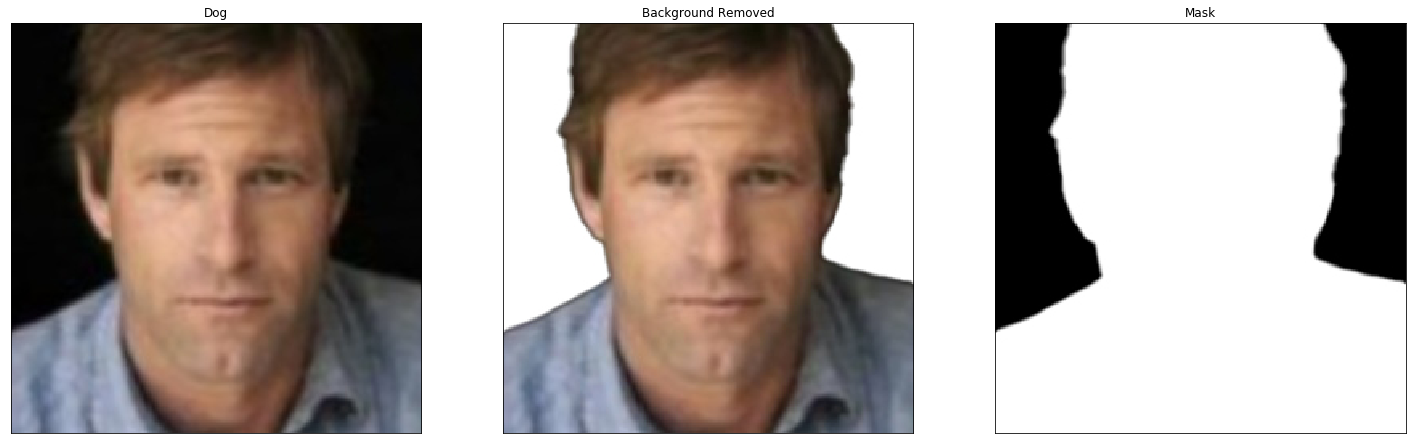

In [661]:
# Model 1

test_image = 'data/person_256/person_0002.jpg'
test_image_bg = 'data/person/person_0002.jpg'
test_image_mask = 'data/person_mask/person_0002.jpg'

fig, axes = plt.subplots(1, 3, figsize = (25, 10))
axes[0].imshow(load_img(test_image))
axes[0].set_title('Dog'), axes[0].set_xticks([]), axes[0].set_yticks([])
axes[1].imshow(load_img(test_image_bg))
axes[1].set_title('Background Removed'), axes[1].set_xticks([]), axes[1].set_yticks([])
axes[2].imshow(load_img(test_image_mask))
axes[2].set_title('Mask'), axes[2].set_xticks([]), axes[2].set_yticks([])

(Text(0.5, 1.0, 'Mask'), [], [])

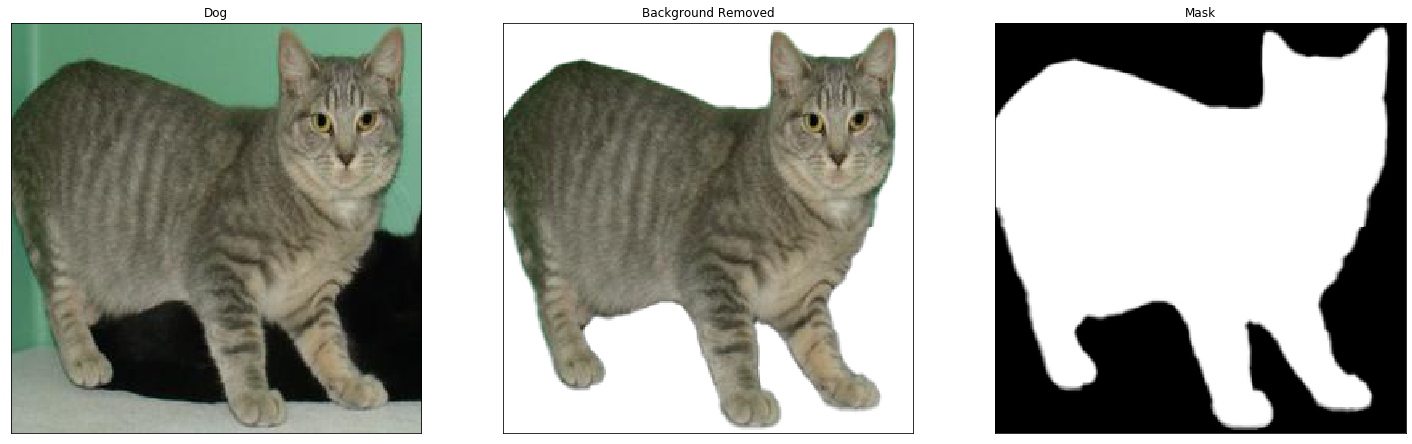

In [605]:
### Example training image and corresponding mask

# Model 2

test_image_bg = 'data/cat/cat_0025.jpg'
test_image = 'data/cat_256/cat_0025.jpg'
test_image_mask = 'data/cat_mask/cat_0025.jpg'

fig, axes = plt.subplots(1, 3, figsize = (25, 10))
axes[0].imshow(load_img(test_image))
axes[0].set_title('Dog'), axes[0].set_xticks([]), axes[0].set_yticks([])
axes[1].imshow(load_img(test_image_bg))
axes[1].set_title('Background Removed'), axes[1].set_xticks([]), axes[1].set_yticks([])
axes[2].imshow(load_img(test_image_mask))
axes[2].set_title('Mask'), axes[2].set_xticks([]), axes[2].set_yticks([])

(Text(0.5, 1.0, 'Mask'), [], [])

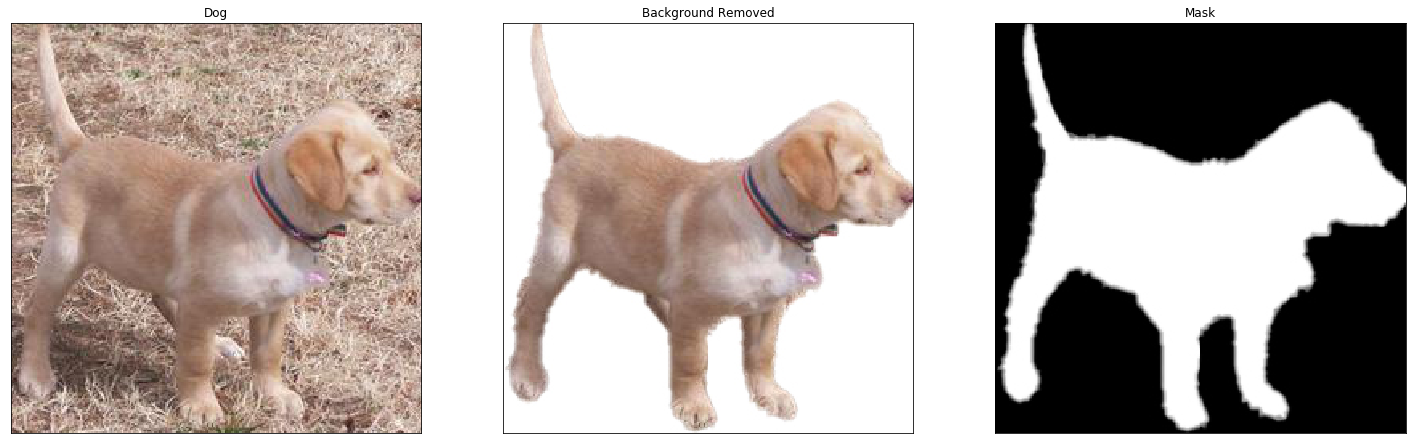

In [604]:
### Example training image and corresponding mask

# Model 3

test_image_bg = 'data/dog/dog_0668.jpg'
test_image = 'data/dog_256/dog_0668.jpg'
test_image_mask = 'data/dog_mask/dog_0668.jpg'

fig, axes = plt.subplots(1, 3, figsize = (25, 10))
axes[0].imshow(load_img(test_image))
axes[0].set_title('Dog'), axes[0].set_xticks([]), axes[0].set_yticks([])
axes[1].imshow(load_img(test_image_bg))
axes[1].set_title('Background Removed'), axes[1].set_xticks([]), axes[1].set_yticks([])
axes[2].imshow(load_img(test_image_mask))
axes[2].set_title('Mask'), axes[2].set_xticks([]), axes[2].set_yticks([])

In [570]:
### Utility functions

def gen_data(test_data, mask_data, total_images, shape = None, batch_size = 5, random = True):
        '''
        Generator that feeds data to the model in batches.
        test_data: dir containing test images.
        mask_data: dir containing corresponding masks of test images.
        shape: size to resize test iamges.
        '''
        
        start = 0
        while True:
            if random:
                org_imgs = np.random.choice(np.arange(len(total_images)), batch_size)
            else:
                org_imgs = range(start, start + batch_size)
                start += batch_size
            imgs, masks = list(), list()
            
            for img in org_imgs:
                
                import_img = load_img(os.path.join(test_data, total_images[img]))
                if shape:
                    res_img = imresize(import_img, shape)
                else:
                    res_img = import_img
                imgs.append(img_to_array(res_img) / 255.0)
                
                mask = load_img(os.path.join(mask_data, total_images[img]))
                if shape:
                    res_mask = imresize(mask, shape)
                else:
                    res_mask = mask
                arr_mask = img_to_array(res_mask) / 255.0
                masks.append(arr_mask[:, :, 0])

            yield np.array(imgs), np.array(masks).reshape(-1, shape[0], shape[1], 1)

def unet(shape, activation = 'sigmoid', tot_filters = 64, filter_incr = 2):
    '''
    Custom U-net implementation for background isolation.
    shape: input shape.
    activation: Output model activation.
    '''

    filters = tot_filters
    nn_input = Input(shape = shape)
    layers = [nn_input]
    residuals = []

    down_1, result_1 = down_sample(nn_input, filters)
    residuals.append(result_1)
    filters *= filter_incr

    down_2, result_2 = down_sample(down_1, filters)
    residuals.append(result_2)
    filters *= filter_incr

    down_3, result_3 = down_sample(down_2, filters)
    residuals.append(result_3)
    filters *= filter_incr
    
    down_4, result_4 = down_sample(down_3, filters)
    residuals.append(result_4)
    filters *= filter_incr

    down_5 = down_sample(down_4, filters, pool = False)
    up_1 = up_sample(down_5, residual = residuals[-1], filters = int(filters/2))
    filters /= filter_incr

    up_2 = up_sample(up_1, residual = residuals[-2], filters = int(filters/2))
    filters /= filter_incr

    up_3 = up_sample(up_2, residual = residuals[-3], filters = int(filters/2))
    filters /= filter_incr

    up_4 = up_sample(up_3, residual = residuals[-4], filters = int(filters/2))

    out = Conv2D(filters = 1, kernel_size = (1, 1), activation = activation)(up_4)
    
    return Model(nn_input, out)

def down_sample(in_layer, filters, padding = 'same', activation = 'relu', pool = True):
    '''
    Combines the upsample image layers.
    '''
    
    conv1 = Conv2D(filters, (3, 3), padding = padding, activation = activation)(in_layer)
    residual = Conv2D(filters, (3, 3), padding = padding, activation = activation)(conv1)
    if pool:
        max_pool = MaxPool2D()(residual)
        return max_pool, residual
    else:
        return residual

def up_sample(in_layer, residual, filters, padding = 'same', activation = 'relu'):
    '''
    Combines the downsampling image layers.
    '''
    
    upsample = UpSampling2D()(in_layer)
    upconv = Conv2D(filters, kernel_size = (2, 2), padding = padding)(upsample)
    concat = Concatenate(axis = 3)([residual, upconv])
    conv1 = Conv2D(filters, (3, 3), padding = padding, activation = activation)(concat)
    conv2 = Conv2D(filters, (3, 3), padding = padding, activation = activation)(conv1)
    return conv2

def jaccard(actual, predicted, smooth = 1):
    '''
    Jaccrd index of the predicted and actual used as an indicator for the image segmentation model.
    '''

    inter = K.sum(K.abs(actual * predicted), axis = [1,2,3])
    union = K.sum(actual, [1,2,3]) + K.sum(predicted, [1,2,3]) - inter
    
    return K.mean((inter + smooth) / (union + smooth), axis = 0)


def dice_coef(actual, predicted, smooth = 1):
    '''
    Dice coefficient (F1 score) of the predicted and actual used as an indicator for the image segmentation model.
    '''
    
    inter = K.sum(actual * predicted, axis = [1,2,3])
    union = K.sum(actual, axis = [1,2,3]) + K.sum(predicted, axis = [1,2,3])
    
    return K.mean((2. * inter + smooth) / (union + smooth), axis = 0)


In [609]:
# Split data to training and testing set

# Model 1
all_images = [file for file in os.listdir(train_images) if os.path.isfile(os.path.join(train_images, file))]
train_image_set, test_image_set = train_test_split(all_images, train_size = 0.8, test_size = 0.2)

# Model 2
all_images2 = [file for file in os.listdir(train2_images) if os.path.isfile(os.path.join(train2_images, file))]
train2_image_set, test2_image_set = train_test_split(all_images2, train_size = 0.8, test_size = 0.2)

# Model 3
all_images3 = [file for file in os.listdir(train3_images) if os.path.isfile(os.path.join(train3_images, file))]
train3_image_set, test3_image_set = train_test_split(all_images3, train_size = 0.8, test_size = 0.2)

# Model 3
all_images4 = [file for file in os.listdir(train4_images) if os.path.isfile(os.path.join(train4_images, file))]
train4_image_set, test4_image_set = train_test_split(all_images4, train_size = 0.8, test_size = 0.2)

In [573]:
%%time

### Train

# Model 1 - People

model1 = unet(shape = [256, 256, 3])
model1.compile(metrics = [jaccard, dice_coef], loss = 'binary_crossentropy', optimizer = Adam(1e-4))
gen = gen_data(train_images, train_images_masks, train_image_set, shape = [256, 256, 3])
model1.fit_generator(gen, steps_per_epoch = 100, epochs = 10)

Epoch 1/10


/Users/pranav/.local/lib/python3.7/site-packages/ipykernel_launcher.py:24: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
/Users/pranav/.local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.


100/100 [==============================] - 558s 6s/step - loss: 0.5009 - jaccard: 0.5805 - dice_coef: 0.7289
Epoch 2/10
100/100 [==============================] - 554s 6s/step - loss: 0.3541 - jaccard: 0.6940 - dice_coef: 0.8174
Epoch 3/10
100/100 [==============================] - 557s 6s/step - loss: 0.3309 - jaccard: 0.7140 - dice_coef: 0.8310
Epoch 4/10
100/100 [==============================] - 550s 5s/step - loss: 0.3144 - jaccard: 0.7224 - dice_coef: 0.8369
Epoch 5/10
100/100 [==============================] - 502s 5s/step - loss: 0.2750 - jaccard: 0.7556 - dice_coef: 0.8592
Epoch 6/10
100/100 [==============================] - 503s 5s/step - loss: 0.2723 - jaccard: 0.7554 - dice_coef: 0.8590
Epoch 7/10
100/100 [==============================] - 501s 5s/step - loss: 0.2572 - jaccard: 0.7675 - dice_coef: 0.8667
Epoch 8/10
100/100 [==============================] - 503s 5s/step - loss: 0.2525 - jaccard: 0.7712 - dice_coef: 0.8692
Epoch 9/10
100/100 [==============================]

In [574]:
%%time

# Model 2

model2 = unet(shape = [256, 256, 3])
model2.compile(metrics = [jaccard, dice_coef], loss = 'binary_crossentropy', optimizer = Adam(1e-4))
gen = gen_data(train2_images, train2_images_masks, train2_image_set, shape = [256, 256, 3])
model2.fit_generator(gen, steps_per_epoch = 100, epochs = 10)

Epoch 1/10


/Users/pranav/.local/lib/python3.7/site-packages/ipykernel_launcher.py:24: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
/Users/pranav/.local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.


100/100 [==============================] - 538s 5s/step - loss: 0.6275 - jaccard: 0.4282 - dice_coef: 0.5930
Epoch 2/10
100/100 [==============================] - 534s 5s/step - loss: 0.5409 - jaccard: 0.4960 - dice_coef: 0.6560
Epoch 3/10
100/100 [==============================] - 539s 5s/step - loss: 0.5202 - jaccard: 0.5264 - dice_coef: 0.6841
Epoch 4/10
100/100 [==============================] - 547s 5s/step - loss: 0.5163 - jaccard: 0.5210 - dice_coef: 0.6788
Epoch 5/10
100/100 [==============================] - 532s 5s/step - loss: 0.4954 - jaccard: 0.5366 - dice_coef: 0.6897
Epoch 6/10
100/100 [==============================] - 550s 5s/step - loss: 0.4580 - jaccard: 0.5752 - dice_coef: 0.7241
Epoch 7/10
100/100 [==============================] - 553s 6s/step - loss: 0.4154 - jaccard: 0.6135 - dice_coef: 0.7531
Epoch 8/10
100/100 [==============================] - 536s 5s/step - loss: 0.4173 - jaccard: 0.6066 - dice_coef: 0.7464
Epoch 9/10
100/100 [==============================]

In [575]:
%%time

# Model 3 - dog

model3 = unet(shape = [256, 256, 3])
model3.compile(metrics = [jaccard, dice_coef], loss = 'binary_crossentropy', optimizer = Adam(1e-4))
gen = gen_data(train3_images, train3_images_masks, train3_image_set, shape = [256, 256, 3])
model3.fit_generator(gen, steps_per_epoch = 100, epochs = 10)

Epoch 1/10


/Users/pranav/.local/lib/python3.7/site-packages/ipykernel_launcher.py:24: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
/Users/pranav/.local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.


100/100 [==============================] - 478s 5s/step - loss: 0.6004 - jaccard: 0.4435 - dice_coef: 0.6074
Epoch 2/10
100/100 [==============================] - 476s 5s/step - loss: 0.5450 - jaccard: 0.4857 - dice_coef: 0.6486
Epoch 3/10
100/100 [==============================] - 477s 5s/step - loss: 0.5057 - jaccard: 0.5252 - dice_coef: 0.6835
Epoch 4/10
100/100 [==============================] - 476s 5s/step - loss: 0.4635 - jaccard: 0.5568 - dice_coef: 0.7091
Epoch 5/10
100/100 [==============================] - 476s 5s/step - loss: 0.4519 - jaccard: 0.5699 - dice_coef: 0.7176
Epoch 6/10
100/100 [==============================] - 476s 5s/step - loss: 0.4157 - jaccard: 0.5933 - dice_coef: 0.7376
Epoch 7/10
100/100 [==============================] - 477s 5s/step - loss: 0.3799 - jaccard: 0.6343 - dice_coef: 0.7699
Epoch 8/10
100/100 [==============================] - 477s 5s/step - loss: 0.3552 - jaccard: 0.6573 - dice_coef: 0.7875
Epoch 9/10
100/100 [==============================]

In [610]:
%%time

# Model 4 - all

model4 = unet(shape = [256, 256, 3])
model4.compile(metrics = [jaccard, dice_coef], loss = 'binary_crossentropy', optimizer = Adam(1e-4))
gen = gen_data(train4_images, train4_images_masks, train4_image_set, shape = [256, 256, 3])
model4.fit_generator(gen, steps_per_epoch = 100, epochs = 10)

Epoch 1/10


/Users/pranav/.local/lib/python3.7/site-packages/ipykernel_launcher.py:24: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
/Users/pranav/.local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.


100/100 [==============================] - 532s 5s/step - loss: 0.5881 - jaccard: 0.4808 - dice_coef: 0.6429
Epoch 2/10
100/100 [==============================] - 530s 5s/step - loss: 0.5190 - jaccard: 0.5302 - dice_coef: 0.6865
Epoch 3/10
100/100 [==============================] - 533s 5s/step - loss: 0.4878 - jaccard: 0.5547 - dice_coef: 0.7066
Epoch 4/10
100/100 [==============================] - 548s 5s/step - loss: 0.4595 - jaccard: 0.5736 - dice_coef: 0.7214
Epoch 5/10
100/100 [==============================] - 548s 5s/step - loss: 0.4421 - jaccard: 0.5979 - dice_coef: 0.7410
Epoch 6/10
100/100 [==============================] - 518s 5s/step - loss: 0.4385 - jaccard: 0.5996 - dice_coef: 0.7435
Epoch 7/10
100/100 [==============================] - 490s 5s/step - loss: 0.4178 - jaccard: 0.6198 - dice_coef: 0.7584
Epoch 8/10
100/100 [==============================] - 480s 5s/step - loss: 0.3894 - jaccard: 0.6445 - dice_coef: 0.7769
Epoch 9/10
100/100 [==============================]

In [667]:
gen_eval = gen_data(train_images, train_images_masks, test_image_set, shape = [256, 256])
scores = model1.evaluate_generator(gen_eval, steps = 100)

/Users/pranav/.local/lib/python3.7/site-packages/ipykernel_launcher.py:24: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
/Users/pranav/.local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.


In [669]:
model1.metrics_names

['loss', 'jaccard', 'dice_coef']

In [668]:
scores

[0.25765445828437805, 0.7489613890647888, 0.8551977276802063]

In [670]:
gen_eval = gen_data(train4_images, train4_images_masks, test4_image_set, shape = [256, 256])
scores = model4.evaluate_generator(gen_eval, steps = 100)

/Users/pranav/.local/lib/python3.7/site-packages/ipykernel_launcher.py:24: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
/Users/pranav/.local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.


In [671]:
scores

[0.3908245861530304, 0.6651507616043091, 0.7936354279518127]

### Testing new images

#### Option 1 - Import the class
#### Option 2 (see readme.md) - Trigger the command line program (app.py)

In [673]:
from app import Classify, Input

In [691]:
img_pranav = 'test/pranav.jpg'
img_tarik = 'test/tarik.jpg'

In [684]:
model = Classify(mode = 'people')
model2 = Classify(mode = 'all')

In [692]:
data = Input(mode = 'file', data = img_pranav)
data2 = Input(mode = 'file', data = img_tarik)

In [693]:
# Pranav
a = model.predict(data)
a2 = model2.predict(data)

# Tarik
b = model.predict(data2)
b2 = model2.predict(data2)

(Text(0.5, 1.0, 'Model 4 Prediction (all)'), [], [])

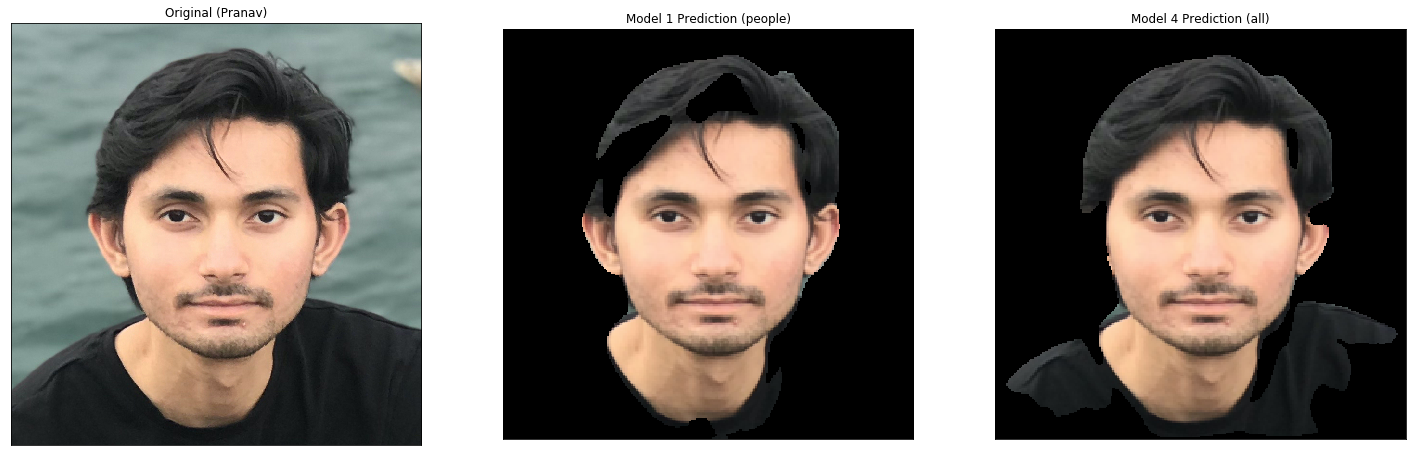

In [686]:
fig, axes = plt.subplots(1, 3, figsize = (25, 10))
axes[0].imshow(load_img(img_pranav))
axes[0].set_title('Original (Pranav)'), axes[0].set_xticks([]), axes[0].set_yticks([])
axes[1].imshow(a)
axes[1].set_title('Model 1 Prediction (people)'), axes[1].set_xticks([]), axes[1].set_yticks([])
axes[2].imshow(a2)
axes[2].set_title('Model 4 Prediction (all)'), axes[2].set_xticks([]), axes[2].set_yticks([])

(Text(0.5, 1.0, 'Model 4 Prediction (all)'), [], [])

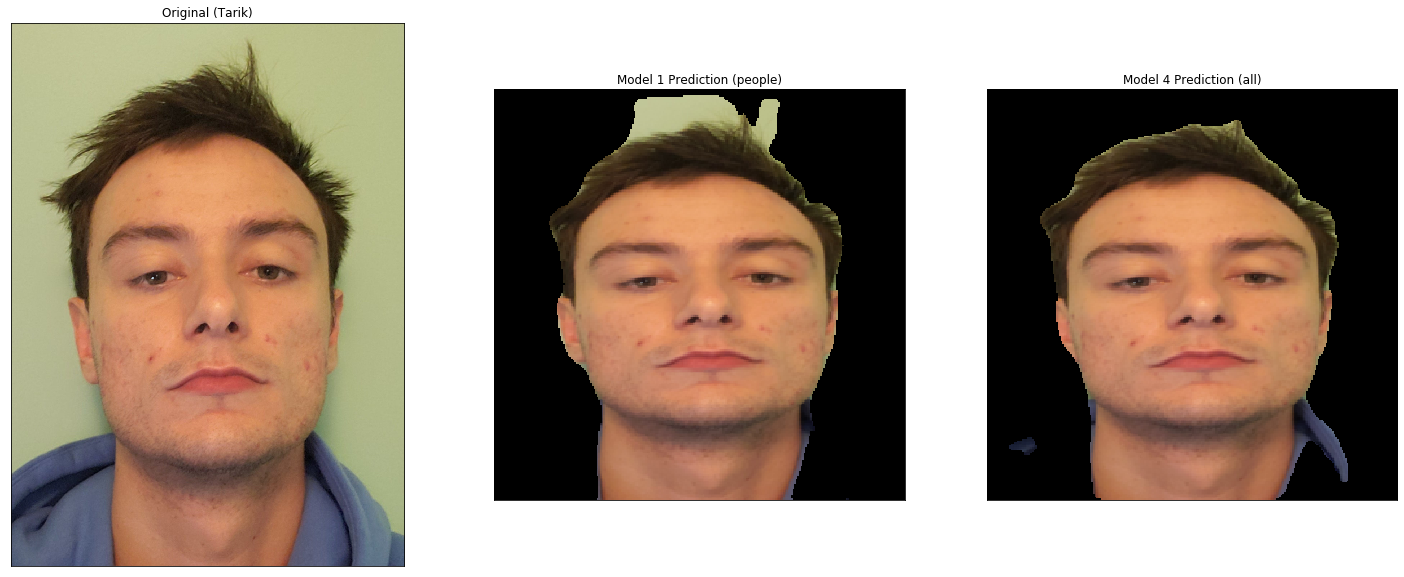

In [694]:
fig, axes = plt.subplots(1, 3, figsize = (25, 10))
axes[0].imshow(load_img(img_tarik))
axes[0].set_title('Original (Tarik)'), axes[0].set_xticks([]), axes[0].set_yticks([])
axes[1].imshow(b)
axes[1].set_title('Model 1 Prediction (people)'), axes[1].set_xticks([]), axes[1].set_yticks([])
axes[2].imshow(b2)
axes[2].set_title('Model 4 Prediction (all)'), axes[2].set_xticks([]), axes[2].set_yticks([])